In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch.nn as nn
from torch import optim

import torchvision
from torchvision import transforms
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


In [3]:
# pre and post processing for images
img_size = 200
style_prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])

im_prep = transforms.Compose([transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])

postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/Users/ianlee/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [4]:
loader = ToTensor()

In [5]:
im = Image.open('./360.jpg')
im_torch = im_prep(im)

In [6]:
loader(im).shape

torch.Size([3, 2048, 4096])

In [7]:
im_torch.shape

torch.Size([3, 2048, 4096])

In [8]:
# Adapted from: https://github.com/bingsyslab/360projection/blob/master/equirectangular.py

def xrotation(th):
    c = np.cos(th)
    s = np.sin(th)
    return np.array([[1, 0, 0], [0, c, s], [0, -s, c]])

def yrotation(th):
    c = np.cos(th)
    s = np.sin(th)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])

def render_image_np(theta0, phi0, fov_h, fov_v, width, img):
    """
    theta0 is pitch
    phi0 is yaw
    render view at (pitch, yaw) with fov_h by fov_v
    width is the number of horizontal pixels in the view
    
    Returns a (height, width, 2) matrix containing the
    pixels to sample from (in the source img)
    to project from sphere->perspective.
    """
    m = np.dot(yrotation(phi0), xrotation(theta0))
  
    (base_height, base_width, _) = img.shape

    height = int(width * np.tan(fov_v / 2) / np.tan(fov_h / 2))
    
    DI = np.ones((height * width, 3), np.int)
    trans = np.array([[2.*np.tan(fov_h / 2) / float(width), 0., -np.tan(fov_h / 2)],
                      [0., -2.*np.tan(fov_v / 2) / float(height), np.tan(fov_v / 2)]])
  
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))
  
    DI[:, 0] = xx.reshape(height * width)
    DI[:, 1] = yy.reshape(height * width)

    v = np.ones((height * width, 3), np.float)

    v[:, :2] = np.dot(DI, trans.T)
    v = np.dot(v, m.T)
  
    diag = np.sqrt(v[:, 2] ** 2 + v[:, 0] ** 2)
    theta = np.pi / 2 - np.arctan2(v[:, 1], diag)
    phi = np.arctan2(v[:, 0], v[:, 2]) + np.pi

    ey = theta * base_height / np.pi
    ex = phi * base_width / (2 * np.pi)

    ex[ex >= base_width] = base_width - 1
    ey[ey >= base_height] = base_height - 1  
  
    # Need to scale grid coordinates between [-1, +1] for use in grid_sample
    ey_grid = ey.reshape(height, width) / (base_height / 2.) - 1
    ex_grid = ex.reshape(height, width) / (base_width / 2.) - 1
    return np.stack([ex_grid, ey_grid], axis=-1)

## Usage

In [9]:
im_var = Variable(im_torch[None])

In [10]:
coords = render_image_np(np.pi/3, np.pi / 3, np.pi / 2, np.pi / 2, 200, np.array(im))
coords_var = Variable(torch.from_numpy(coords.astype(np.float32))[None], requires_grad=False)




In [11]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [12]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [13]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [14]:
#load images, ordered as [style_image, content_image]
style_img_name = 'vangogh_starry_night.jpg'

style_img = Image.open(image_dir + style_img_name)

style_img_var = Variable(style_prep(style_img).unsqueeze(0))
# if torch.cuda.is_available():
#     projections_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
# else:
#     imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(im_var.data.clone(), requires_grad=True)

In [15]:
# #display images
# for img in imgs:
#     imshow(img);show()
opt_img.shape

torch.Size([1, 3, 2048, 4096])

In [16]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_img_var, style_layers)]
# l_projection_targets = [[A.detach() for A in vgg(projection_image, content_layers)] for projection_image in projections_image]
# l_targets = [style_targets + projection_target for projection_target in l_projection_targets]




None
None
None
None


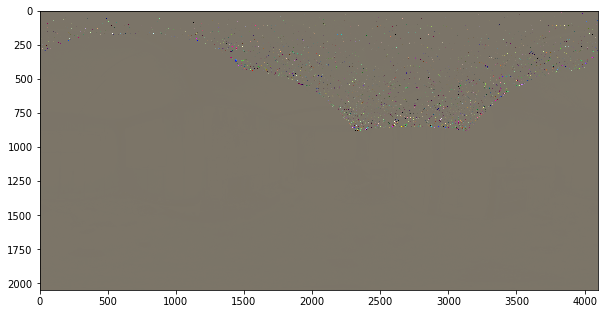

In [19]:
#run style transfer
max_iter = 2
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        projection_var = F.grid_sample(opt_img, coords_var)
        out = vgg(projection_var, loss_layers)
        
        projection_im_var = F.grid_sample(im_var, coords_var)
        projection_targets = [A.detach() for A in vgg(projection_im_var, content_layers)]
        targets = style_targets + projection_targets

        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        
        loss.backward()
        print(projection_var.grad)
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
out_img.save("3_1.png")

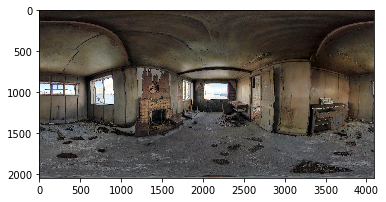

In [18]:
imshow(im)